<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center>  Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. 

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите тетрадку в соответствующем Peer Review. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/1EbjK7-hF-Gepi6RH-K5I2XeiYGRoY0LNDx03QmLu9Xo). 

## Часть 1. Построение признаков

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from datetime import datetime, date, time

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'capstone_user_identification'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [3]:
def read_file_sites_times_user(file_name):
    with open(file_name,'r') as f:
        f.readline() #пропускаем стороку с заголовками
        times_sites=[(line[:-1].split(',')[0],line[:-1].split(',')[1])  for line in f.readlines() if line!='\n']
    times =[datetime.strptime(x[0], "%Y-%m-%d %H:%M:%S") for x in times_sites]
    sites =[x[1]  for x in times_sites]
    user_id=int(file_name[:-4].split('user')[-1])
    return sites, times, user_id

In [4]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    with open(site_freq_path,'rb') as f:
        site_freq=pickle.load(f)
    #лист сессий
    session_list=[]
    #обрабатываем файлы в директории
    file_list=glob(path_to_csv_files)
    for file_name in tqdm_notebook(sorted(file_list)):
        with open(file_name,'r') as f:
            websites,times, user_id=read_file_sites_times_user(file_name)
            
        #список сайтов, заменяем адреса на индексы 
        rest = [ site_freq[ws][0] for ws in websites ] 
        #определяем количество сессий и дополняем список нулями
        if len(rest)%window_size==0:
            #если длина списка кратна длине окна
            N_sessions=int(len(rest)/window_size)
            rest.extend(list([0]*(session_length-window_size)))
        else:
            #если длина списка не кратна длине окна
            N_sessions=int(len(rest)/window_size)+1
            rest.extend(list([0]*(session_length-len(rest)%window_size)))

        #делим на сессии
        for i in range(N_sessions):
            sess=rest[i*window_size:i*window_size+session_length]
            #определяем время начала и конца сессии
            start_time=times[i*window_size]
            if 0 in sess:
                end_time=times[i*window_size+sess.index(0)-1] #конец сессии
                unique_s=set(sess)             #считаем уникальные сессии
                unique_s.pop()
                unique_sites=len(unique_s)
            else:
                end_time=times[i*window_size+session_length-1]  #конец сессии
                unique_sites=len(set(sess))    #считаем уникальные сессии
            dl=end_time-start_time
            session_timespan=dl.days*24*3600+dl.seconds
            #добавляем признаки
            sess.extend([session_timespan,unique_sites,start_time.hour,start_time.weekday(),user_id])
            session_list.append(sess)
            
            
    #создаем имена для дата фрейма с заданный длинной сессий
    df_sessions=pd.DataFrame(session_list,columns=feature_names)
    return df_sessions

**Проверим функцию на игрушечном примере.**

In [5]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'user_id']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '3users/*.csv'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

In [6]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,user_id
0,3,2,2,7,2,1,8,5,9,10,7998,8,9,4,1
1,3,1,1,1,0,0,0,0,0,0,60,2,12,4,1
2,3,2,6,6,2,0,0,0,0,0,7935,3,9,4,2
3,4,1,2,1,2,1,1,5,11,4,7998,5,9,4,3
4,4,1,2,0,0,0,0,0,0,0,1471,3,12,4,3


In [7]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,user_id
0,3,2,2,7,2,1,8,5,9,10,7998,8,9,4,1
1,3,1,1,1,0,0,0,0,0,0,60,2,12,4,1
2,3,2,6,6,2,0,0,0,0,0,7935,3,9,4,2
3,4,1,2,1,2,1,1,5,11,4,7998,5,9,4,3
4,4,1,2,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [8]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '10users/*.csv'), 
                    site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),
                                  feature_names=feature_names, session_length=10)


Wall time: 4.41 s


In [9]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,user_id
0,192,577,133,3,133,133,3,133,203,133,33,5,8,4,31
1,423,193,679,255,133,31,393,3552,220,55,284,10,8,4,31
2,55,3,55,55,5,295,423,338,901,55,258,7,8,4,31
3,481,3398,481,55,55,55,55,946,201,124,30,6,8,4,31
4,349,55,5,3634,259,211,3643,2169,689,2169,6,9,8,4,31


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [10]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '150users/*.csv'), 
                    site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'),
                                  feature_names=feature_names, session_length=10)


Wall time: 37.5 s


In [11]:
train_data_150users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,user_id
0,1,1,4,2,1,4,1,2,1291,321,57,5,8,4,6
1,2,23,1508,1291,321,321,113,73,49,49,1618,8,8,4,6
2,321,205,1,1,1,1,73,321,2,1,2010,5,8,4,6
3,1,1,7177,7177,5768,7177,7177,1,35,1,2006,4,9,4,6
4,1,1,76,1,58,50,58,50,83,76,10,5,9,4,6


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [12]:
new_features_10users = train_data_10users[['session_timespan', '#unique_sites', 'start_hour',  'day_of_week']]
new_features_150users = train_data_150users[['session_timespan', '#unique_sites', 'start_hour','day_of_week']]

In [13]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

**<font color='red'>Вопрос 1. </font> Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [14]:
np.median( train_data_10users['session_timespan'])

37.0

**<font color='red'>Вопрос 2. </font> Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [15]:
np.median( train_data_10users['day_of_week'])

2.0

**<font color='red'>Вопрос 3. </font>Выведите медианный час начала сессии для сессий 150 пользователей.**

In [16]:
np.median( train_data_150users['start_hour'])

13.0

**<font color='red'>Вопрос 4. </font>Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [17]:
np.median( train_data_150users['#unique_sites'])

7.0

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [18]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['user_id'].map(id_name_dict)

In [19]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

In [20]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,user_id,target
0,192,577,133,3,133,133,3,133,203,133,33,5,8,4,31,John
1,423,193,679,255,133,31,393,3552,220,55,284,10,8,4,31,John
2,55,3,55,55,5,295,423,338,901,55,258,7,8,4,31,John
3,481,3398,481,55,55,55,55,946,201,124,30,6,8,4,31,John
4,349,55,5,3634,259,211,3643,2169,689,2169,6,9,8,4,31,John


**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

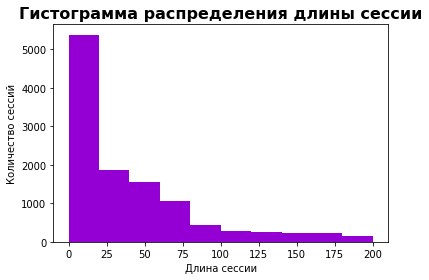

In [21]:
plt.hist(train_data_10users['session_timespan'],color='darkviolet',range=[0,200])
plt.title('Гистограмма распределения длины сессии', fontweight='bold',size=16)
plt.ylabel('Количество сессий')
plt.xlabel('Длина сессии')
plt.show()

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

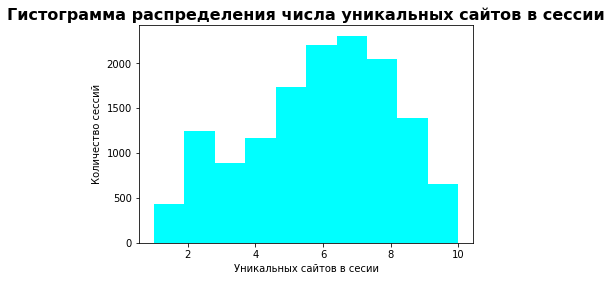

In [22]:
plt.hist(train_data_10users['#unique_sites'],color='aqua')
plt.title('Гистограмма распределения числа уникальных сайтов в сессии', fontweight='bold',size=16)
plt.ylabel('Количество сессий')
plt.xlabel('Уникальных сайтов в сесии')
plt.show()

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

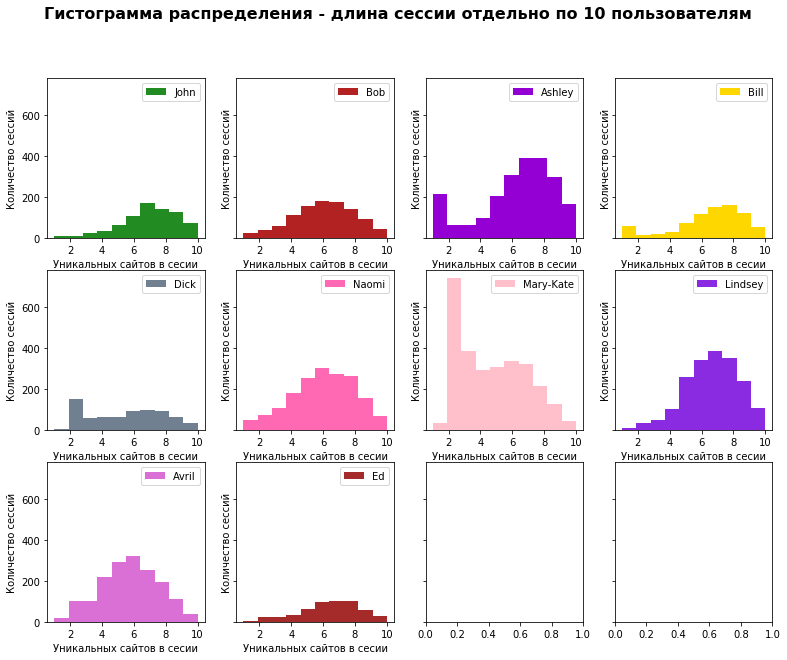

In [23]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(13, 10),sharey=True)
fig.suptitle(u'Гистограмма распределения - длина сессии отдельно по 10 пользователям', fontweight='bold',size=16)

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
    row,col=int(idx/4),idx%4
    username=id_name_dict[user]
    axes[row,col].set_ylabel('Количество сессий')
    axes[row,col].set_xlabel('Уникальных сайтов в сесии')
    axes[row,col].hist(sub_df['#unique_sites'],color=color_dic[username], label=username)
    axes[row,col].legend()

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

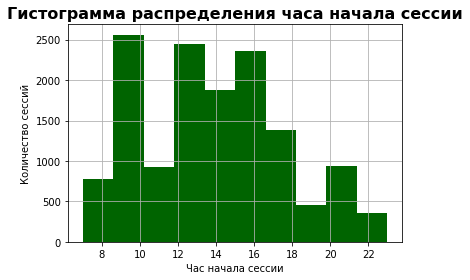

In [24]:
ax = train_data_10users['start_hour'].hist(color='darkgreen')
ax.set_title('Гистограмма распределения часа начала сессии', fontweight='bold',size=16)
ax.set_xlabel(u'Час начала сессии')
ax.set_ylabel(u'Количество сессий')
plt.show()

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

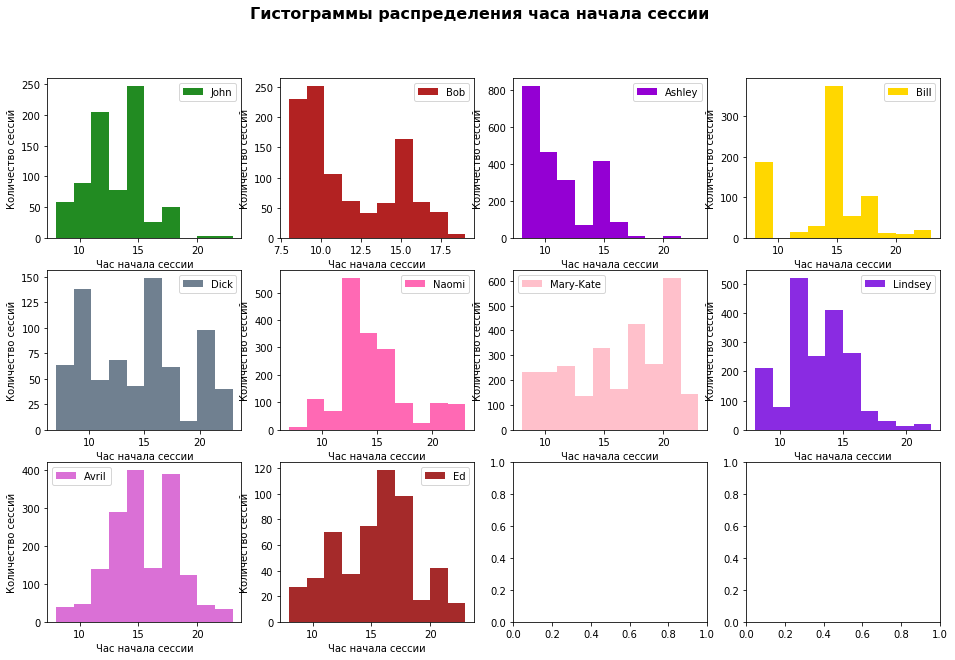

In [25]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
fig.suptitle('Гистограммы распределения часа начала сессии', fontweight='bold',size=16)

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
    row,col=int(idx/4),idx%4
    username=id_name_dict[user]
    axes[row,col].set_ylabel('Количество сессий')
    axes[row,col].set_xlabel('Час начала сессии')
    axes[row,col].hist(sub_df['start_hour'],color=color_dic[username], label=username)
    axes[row,col].legend()

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

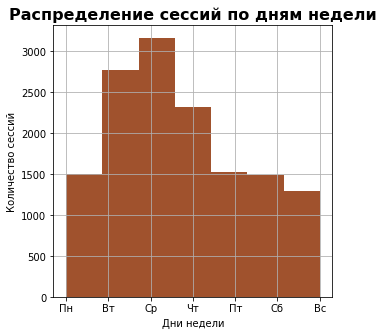

In [26]:
ax = train_data_10users['day_of_week'].hist(range=(0,6),color='sienna',figsize=(5,5),bins=7)
ax.set_xlabel(u'Дни недели')
ax.set_ylabel(u'Количество сессий')
ax.set_title(u'Распределение сессий по дням недели', fontweight='bold', size=16)
ax.set_xticks(range(7))
ax.set_xticklabels([u'Пн', u'Вт', u'Ср', u'Чт', u'Пт', u'Сб', u'Вс'])
plt.show()

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

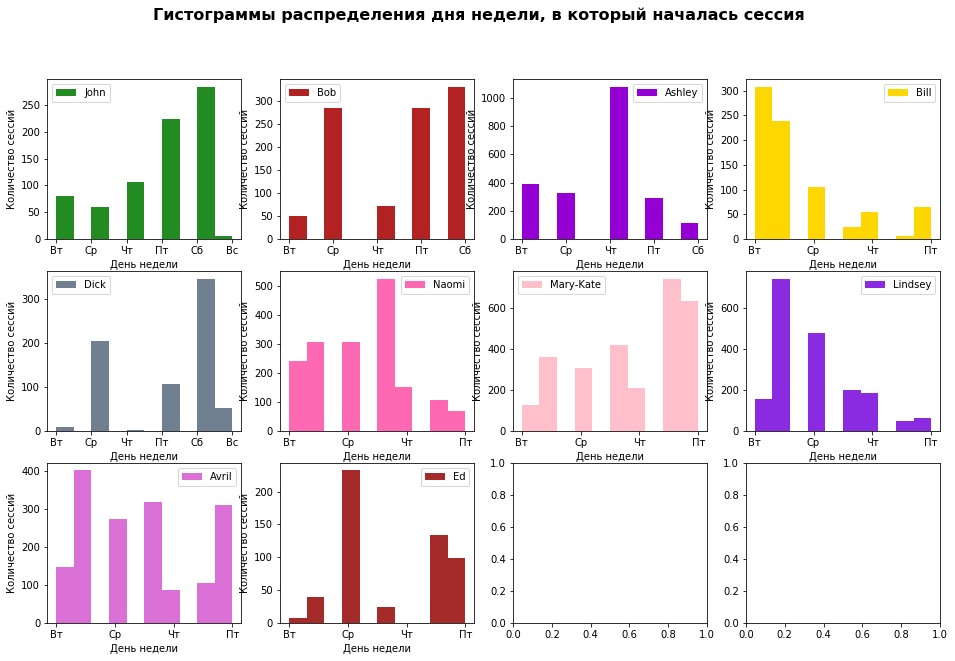

In [27]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
fig.suptitle('Гистограммы распределения дня недели, в который началась сессия', fontweight='bold', size=16)

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
    row,col=int(idx/4),idx%4
    username=id_name_dict[user]
    axes[row,col].set_xlabel('День недели')
    axes[row,col].set_ylabel('Количество сессий')
    axes[row,col].set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] )
    axes[row,col].hist(sub_df['day_of_week'],color=color_dic[username], label=username)
    axes[row,col].legend()

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

__31: 'John'.__ Длина сессии - убывающее, без особенностей Число уникальных сайтов в сессии - наиболее частое- 6, похоже на других Час начала сессии - активность в рабочие часы, максимум в 15 День недели - активность в рабочие дни, отсутвует в Вскр.

__33: 'Bob'.__ Длина сессии - без особенностей Число уникальных сайтов в сессии - наиболее частое- 7, похоже на других Час начала сессии - активность в рабочие часы, два максимума в 10 и 15 День недели - активность в рабочие дни Вт,Чтв,Птн. , отсутвует в выходные.

__39: 'Ashley'.__ Длина сессии - тяжелый хвост в распределии Число уникальных сайтов в сессии - присутствует пик на 1, наиболее частое- 7,8 Час начала сессии - активность в рабочие часы, максимум утром в 10, а также 15 День недели - активность в рабочие дни, пик в Срд, отсутвует в выходные.

__50: 'Bill'.__ Длина сессии - присутствует пик 48-49 Число уникальных сайтов в сессии - присутствует пик на1, наиболее частое- 8, Час начала сессии - активность в рабочие часы, присутствует в вечерние часы , максимум в 15 День недели - активность все дни, убывающая с Пнд.

__100: 'Dick'.__ Длина сессии - присуствует дополнительный пик 50-70 Число уникальных сайтов в сессии - отличительное наиболее частое- 2 Час начала сессии - активность весь день, с понижением в 13 и 19 День недели - активность в Ср. и Пт.Суб.Вскр, отсутвует в Пнд.

__127: 'Naomi'.__ Длина сессии - без особенностей Число уникальныхсайтов в сессии - наиболее частое- 6, похоже на других Час начала сессии - активность весть день, максимум в рабочие часы в 14 День недели - активность всю неделю, максимум в Чтв.

__128: 'Mary-Kate'.__ Длина сессии - выделяется пик на 40-60 Число уникальных сайтов в сесси - отличное от других распределение с макс- 2 Час начала сессии - активность весь день, в целом увеличивающаяся к 20 День недели - активность все дни, с максимумом в выходные дни.

__207: 'Lindsey'.__ Длина сессии - без особенностей Число уникальных сайтов в сесси - наиболее частое- 7, похоже на других Час начала сессии - активность в рабочие часы, максимум в 13,15 присутствует вечерняя активность День недели - активность все дни, более в рабочие дни, макс Вт.

__237: 'Avril'.__ Длина сессии - без особенностей Число уникальных сайтов в сесси - наиболее частое- 6, похоже на других Час начала сессии - активность весь день, максимум в 14 и 17 День недели - активность все дни, макс Вт.

__241: 'Ed'.__ Длина сессии - без особенностей Число уникальных сайтов в сесси - наиболее частое- 7,8 похоже на других Час начала сессии - активность весь день , максимум в 16 День недели - активность в основном в Ср.Сб.Вскр., отсутствует в Птн.

Видим, что у Mary-Kate, Ashley, Lindsey и, возможно, у Naomi - явное преимущество по количеству сессий. По уникальным сайтам распределение у всех в основном одинаковое, немного выделяются Mary-Kate и Dick - на 2-х сайтах у них есть выброс. По часу начала сессии выделяются John, Ed - у них распределение "одногорбое". Возможно, та же группа, а возможно другая - Lindsey и Mary-Kate - у них выбросы очень близко друг к другу расположены. По дням недели можно выделить две группы: John, Bill и Ashley, Naomi, Lindsey. У остальных распределения на мой взгляд беспорядочно разные.

Таким образом совокупно получается что пользователи с женскими именами довольно сильно отличаются по поведению от пользователей с мужскими. Причём лидирует по количеству признаков - Lindsey.

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [28]:
with open(os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'), 'rb') as site_freq_pkl:
    site_freq_10users = pickle.load(site_freq_pkl)

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [29]:
popular_list=sorted(site_freq_10users.items(), key=lambda x: x[1][1], reverse=True)[:10]
top10_freqs =[fr for (site,(site_id, fr)) in popular_list]
top10_sites =[site for (site,(site_id, fr)) in popular_list]

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

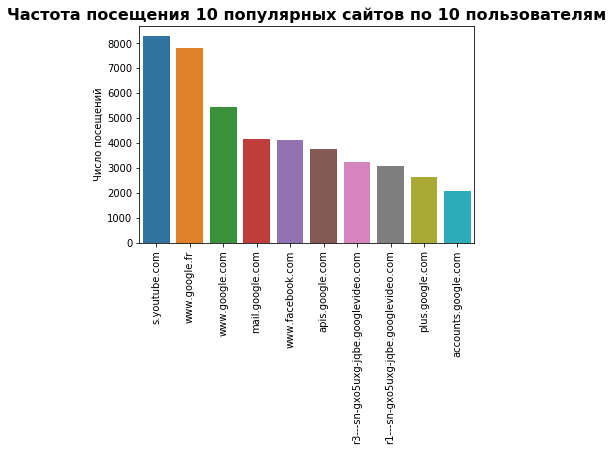

In [30]:
ax=sns.barplot( x=top10_sites,y=top10_freqs)
ax.set_title(u'Частота посещения 10 популярных сайтов по 10 пользователям', fontweight='bold',size=16)
ax.set_ylabel(u'Число посещений')
ax.set_xticklabels(top10_sites,rotation='vertical')
plt.show()

## Часть 3. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [31]:
def feature_engineering(path_to_csv_files, site_freq_path, features,
                                    session_length=10, window_size=10):
        #читаем частотный словарь
    with open(site_freq_path,'rb') as f:
              site_freq=pickle.load(f)
    #список популярных сайтов топ 30
    top30_names=sorted(site_freq.keys(), key=lambda key: site_freq[key][1], reverse=True )[:30]
    top30=[site_freq[key][0] for key in top30_names]
    #лист сессий
    session_list=[]
    #обрабатываем файлы в директории
    file_list=glob(path_to_csv_files)
    for file_name in tqdm_notebook(sorted(file_list)):
        #читаем файл
        with open(file_name,'r') as f:
            websites,times, user_id=read_file_sites_times_user(file_name)
        
        #продолжительность пребывания на каждом сайте , секунды
        site_timespan=[(times[i+1]-times[i]).seconds for i in range(len(times)-1) ]
        site_timespan.append(1)    
        #список сайтов, заменяем адреса на индексы 
        sites_id = [ site_freq[ws][0] for ws in websites ]
        #определяем количество сессий и дополняем список нулями
        if len(sites_id)%window_size==0:
            #если длина списка кратна длине окна
            N_sessions=int(len(sites_id)/window_size)
            sites_id.extend(list([0]*(session_length-window_size)))
            site_timespan.extend(list([0]*(session_length-window_size)))
        else:
            #если длина списка не кратна длине окна
            N_sessions=int(len(sites_id)/window_size)+1
            sites_id.extend(list([0]*(session_length-len(sites_id)%window_size)))
            site_timespan.extend(list([0]*(session_length-len(sites_id)%window_size)))
        #делим на сессии
        for i in range(N_sessions):
            #делим список сайтов на сессии
            sess=sites_id[i*window_size:i*window_size+session_length]
            #делим cписок продолжительности времени на сайте на сессии
            sess_ts=site_timespan[i*window_size:i*window_size+session_length]
            #определяем время начала и конца сессии
            start_time=times[i*window_size]
            if 0 in sess:
                end_time=times[i*window_size+sess.index(0)-1] #конец сессии
                unique_s=set(sess)             #считаем уникальные сайты в сессии
                unique_s.pop()
                unique_sites=len(unique_s)
            else:
                end_time=times[i*window_size+session_length-1]  #конец сессии
                unique_sites=len(set(sess))    #считаем уникальные сессии
            dl=end_time-start_time
            session_timespan=dl.days*24*3600+dl.seconds
            #добавляем признаки
            sess_fe=[]
                    #sess.extend([session_timespan,unique_sites,start_time.hour,start_time.weekday()])
            sess_fe.append(session_timespan)      #длина сессии, сек
            sess_fe.append(unique_sites)          #число уникальных сайтов
            sess_fe.append(start_time.hour)       #час начала сессии
            sess_fe.append(start_time.weekday())  #день недели сессии
            
            #вычисляем новые признаки
            site_and_timesp=zip(sess,sess_ts)
            #время, проведенное на топ-30 в сессии 
            topsite_timespand=list([0]*30)
            for i, site in enumerate(top30):
                    if site in sess:
                        topsite_timespand[i]=sum([tm  for (st, tm) in site_and_timesp if st==site ])
            sess_fe.extend(topsite_timespand)            
            #три значимые сайта, т.е. с наибольшим временем 
            sorted_sites = sorted(site_and_timesp, key=lambda x: x[1], reverse=True)[:3]
            target_sites= [s for s,t in sorted_sites]
            sess_fe.extend(target_sites)    
            #доля времени на значимых сайтах
            target_times= [t for s,t in sorted_sites]
            if sum(sess_ts)==0:
                target_time_proportion=0
            else:
                target_time_proportion=sum(target_times)/sum(sess_ts)
            sess_fe.append(target_time_proportion)
            #пользователь
            sess_fe.append(user_id)
            #обединяем сессию и признаки, добавляем с список сессий
            sess.extend(sess_fe)
            session_list.append(sess)
            
            
    #создаем имена для дата фрейма с заданный длинной сессий
    col_names=['site'+str(i) for i in range(1,session_length+1)]
    col_names.extend(features)
    df_sessions=pd.DataFrame(session_list,columns=col_names)
    
    return df_sessions

In [32]:
features_1=['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week']
features_2=['top'+str(i) for i in range(1,30+1)]
features_3=['target_site1','target_site2','target_site3', 'target_time_proportion', 'user_id']
fe=features_1+features_2+features_3

In [33]:
%%time
new_features_10users = feature_engineering(os.path.join(PATH_TO_DATA,'10users/*.csv'), \
                                           os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),\
                                           fe, session_length=10, window_size=10)


Wall time: 5.26 s


In [34]:
%%time
new_features_150users = feature_engineering(os.path.join(PATH_TO_DATA,'150users/*.csv'), \
                                           os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'),\
                                           fe, session_length=10, window_size=10) 


Wall time: 41.9 s


**10. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

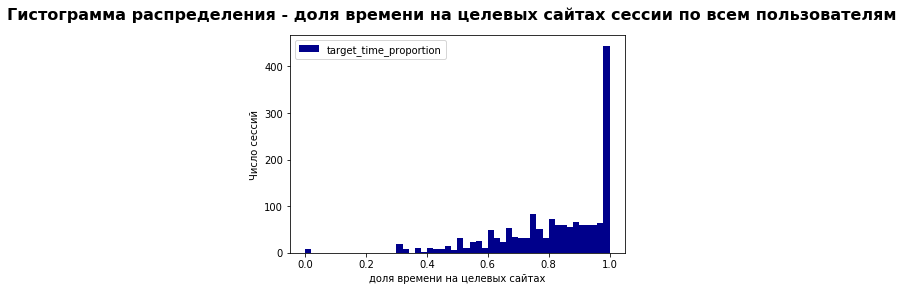

In [35]:
fig, ax = plt.subplots()
fig.suptitle(u'Гистограмма распределения - доля времени на целевых сайтах сессии по всем пользователям', fontweight='bold',size=16)
ax.set_xlabel(u'доля времени на целевых сайтах')
ax.set_ylabel(u'Число сессий')
ax.hist(new_features_10users['target_time_proportion']  , bins=50,align=u'mid' , color='darkblue')
ax.legend(loc='best')
plt.show()

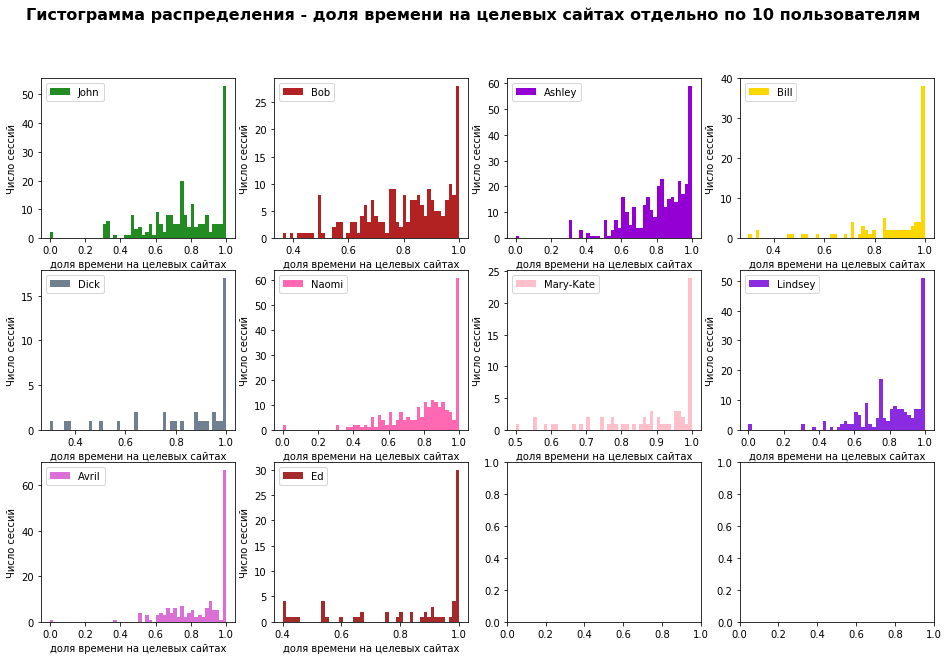

In [36]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
fig.suptitle(u'Гистограмма распределения - доля времени на целевых сайтах отдельно по 10 пользователям', fontweight='bold',size=16)
for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users, 'user_id')): 
    name=id_name_dict[user]
    ax=axes.ravel()[idx]
    ax.set_xlabel(u'доля времени на целевых сайтах') 
    ax.set_ylabel(u'Число сессий')
    ax.hist(sub_df['target_time_proportion']  , bins=50 ,align=u'mid' ,label=name , color=color_dic[name])
    ax.legend(loc='best')
plt.show()

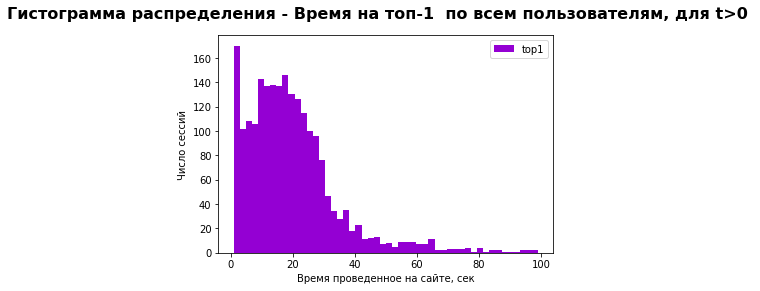

In [37]:
fig, ax = plt.subplots()
fig.suptitle(u'Гистограмма распределения - Время на топ-1  по всем пользователям, для t>0 ', fontweight='bold',size=16)
ax.set_xlabel(u'Время проведенное на сайте, сек')
ax.set_ylabel(u'Число сессий')
ax.hist(new_features_10users[new_features_10users.top1!=0].top1  , bins=50, range=(1,99), align=u'mid' , color='darkviolet')
ax.legend(loc='best')
plt.show()

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [38]:
new_fe_columns=new_features_10users.columns
selected_features_10users = new_features_10users[new_fe_columns]
selected_features_150users = new_features_150users[new_fe_columns]

In [39]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

### Критерии оценки работы (только для Peer Review в специализации):
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 